# Import

In [1]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray
import xarray as xr
from numba import cuda
import keras
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, UpSampling2D, Resizing
from keras.mixed_precision import set_global_policy

# Burned area dataset

### Helper functions

In [26]:
def latitude_converted(lat: float):
    """
    Convert latitude value to value between 0 and 720 (0.25 degree representation of latitude)
    :param lat: The actual latitude we want to covert to the 720 format
    """
    return (90 - lat) * 4

def longitude_converted(lon: float):
    """
    Convert longitude value to value between 0 and 1440 (0.25 degree representation of longitude)
    :param lon: The actual longitude we want to convert to the 1440 format 
    """
    return (-180 - lon) * -4

Function that loads a netCDF File

In [17]:
def load_netcdf_file(path: str):
    """
    Open a netCDF File, NOTE: After being done with the file don't forgoet to use nc_file.close() to close the file.
    :param path: The absolute path to the netCDF file.
    """
    nc_file = nc.Dataset(file, 'r')
    return nc_file

file = "E:\\Project\\Urban computing\\data\Burned area patch\\2003\\20030801-ESACCI-L4_FIRE-BA-MODIS-fv5.1.nc"
data = load_netcdf_file(file)

Create the South korea matrix from the "burned_area" variable in the netCDF file

In [ ]:
# Full South-Korea
south_korea_lat_min = 36
south_korea_lat_max = 39
south_korea_lon_min = 126
south_korea_lon_max = 129

In [18]:
def create_ba_matrix_one_month(nc_file):
    """
    Create the Burned Area matrix for South Korea NOTE: Do not forget to call nc_file.close() after finishing with the file.
    :param nc_file: The netCDF Dataset of the monthly data.
    """
    ba_matrix = np.array(nc_file.variables['burned_area'])
    
    # Convert lat and long to the 720 and 1440 degree format respectively
    max_lat_idx = latitude_converted(south_korea_lat_max)
    min_lat_idx = latitude_converted(south_korea_lat_min)
    max_lon_idx = longitude_converted(south_korea_lon_max)
    min_lon_idx = longitude_converted(south_korea_lon_min)

    # Create the south korea BA matrix
    south_korea_matrix = ba_matrix[:, max_lat_idx:min_lat_idx, min_lon_idx:max_lon_idx]
    return south_korea_matrix


# south_korea = create_ba_matrix_one_month(data)
# south_korea.shape

### Combine data
Create a single dataset which contains the korea BA matrix over all the months of the years range 2001-2020

In [15]:
def combine_data(root_folder):
    """
    Combine data from multiple NetCDF files.
    :param root_folder: The root folder containing yearly subfolders.
    :return: Combined dataset for South Korea.
    """
    combined_data = None

    for year_folder in os.listdir(root_folder):
        year_path = os.path.join(root_folder, year_folder)

        for month_file in os.listdir(year_path):
            file_path = os.path.join(year_path, month_file)

            # Open the NetCDF file
            with nc.Dataset(file_path, 'r') as nc_file:
                south_korea_data = create_ba_matrix_one_month(nc_file)

                if combined_data is None:
                    combined_data = south_korea_data
                else:
                    # Combine the data along the time dimension (assuming the first dimension is time)
                    combined_data = np.concatenate((combined_data, south_korea_data), axis=0)

    return combined_data

# Specify the root folder where your data is stored
data_root_folder = 'E:\\Project\\Urban computing\\data'

# Call the combine_data function
combined_data = combine_data(data_root_folder)

# Now, combined_data contains the aggregated burned area data for South Korea from all files.
np.save(file="combined_data.npy" , arr=combined_data)

In [19]:
loaded_data = np.load('combined_data.npy')
loaded_data.shape
loaded_data[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

# Load GeoTIFF (Burned area pixel data)

In [2]:
# Small bounding box for South-Korea, use 36,39,126,129 for the full South-Korea map
south_korea_lat_min = 38
south_korea_lat_max = 39
south_korea_lon_min = 126
south_korea_lon_max = 128.5

In [3]:
def pixel_long_to_idx(long: float):
    if long < 52.999301 or  long > 179.99999999952965:
        return ValueError
    return (long - 52.999301) / 0.0022457331

def pixel_lat_to_idx(latitude: float):
    if latitude < 0 or  latitude > 83.00004990518016:
        return ValueError
    return (latitude - 1.4210854715202004e-14) / 0.0022457331

# Function to clip the TIFF file
def clip_tiff(file_path, lon_min, lon_max, lat_min, lat_max):
    data = rioxarray.open_rasterio(file_path)
    clipped_data = data.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
    return clipped_data


In [4]:
# Base directory containing the folders
base_dir = "E:\\Project\\Urban computing\\data\\Pixel Data"

# Dataset to store the clipped data
dataset = []
counter = 0
# Loop through each year directory
for year in os.listdir(base_dir):
    year_dir = os.path.join(base_dir, year)

    # Loop through each subdirectory in the year directory
    for root, dirs, files in os.walk(year_dir):
        for file in files:
            if file.endswith("-CL.tif"):
                file_path = os.path.join(root, file)

                # Extract the 'month' from the directory name if necessary
                month = os.path.basename(root)  # or any other logic to determine the month from the folder name

                # Clip the data and add to the dataset
                clipped_data = clip_tiff(file_path, south_korea_lon_min, south_korea_lon_max, south_korea_lat_min, south_korea_lat_max)
                clipped_data = clipped_data.squeeze() # Remove the band data
                clipped_data = clipped_data.assign_coords({"month": counter})
                clipper_data = clipped_data.expand_dims(dim = "month")
                dataset.append(clipped_data)
                counter += 1


In [5]:
# Concatenate all DataArrays in the dataset list along the 'month' dimension
combined_data = xr.concat(dataset, dim="month")

# combined_data.rio.to_raster("kr_data_test.tif")


In [156]:
# data_arrays = [item[2] for item in dataset]  # Extract the DataArray from each tuple
# print(dataset[150][2])

# # Stack the arrays along a new axis (0th axis for time)
# combined_numpy_array = np.stack(data_arrays, axis=0)

# # Print the shape of the resulting NumPy array
# reduced_dim = np.squeeze(combined_numpy_array)
# print(reduced_dim.shape)
# np.save(arr=reduced_dim, file="south_korea_CL.npy")

loaded_data = rioxarray.open_rasterio("kr_data_test.tif")


# Create dataset for small bounding box model
This dataset is for the last model in this notebook. We focus on a small subsection of korea that in general has a lot of fires

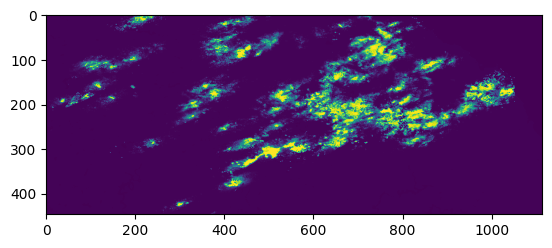

In [6]:
fig, ax = plt.subplots()
object = ax.imshow(combined_data[3])
plt.show()

In [7]:
for i, data in enumerate(combined_data):
    temp = np.where(data > 50, 1, 0)
    temp2 = np.where(data > 0, 1, 0)
    new_data = np.zeros(shape=data.shape) + temp + temp2
    combined_data[i] = new_data

In [8]:
np.unique(combined_data[3])

array([0, 1, 2], dtype=uint8)

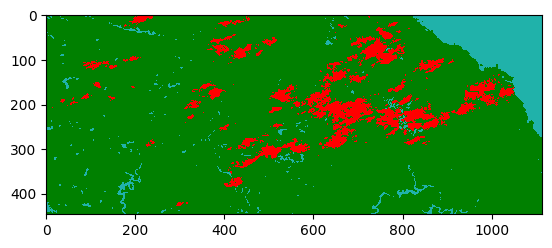

In [9]:
fig, ax = plt.subplots()
cmap = mpl.colors.ListedColormap(["lightseagreen", "green", "red"])
test = ax.imshow(combined_data[3], cmap=cmap, vmin=0, vmax=2)
plt.show()

# Spatio-temporal forecasting using ConvLSTM Architecture

In [10]:
new_array = combined_data.to_numpy()
new_array = new_array.astype(np.dtypes.Float16DType)
np.save('training_array_f16_small_bb.npy', new_array)

In [49]:
# Load saved data
training_data = np.load("training_array_f16.npy")

In [46]:
np.unique(training_data[3])

array([0., 1., 2.], dtype=float16)

# Helper functions

In [2]:
def create_windowed_dataset(data, window_size):
    """
    Created windowed dataset
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [5]:
def train_test_split(X, y, train_size, test_size, val_size):
    """
    Create a train/test/val split using already created X and y data.
    """

    # Define the split indices
    train_end = train_size
    test_end = train_end + test_size
    val_end = test_end + val_size


    # Split the dataset
    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:test_end], y[train_end:test_end]
    X_val, y_val = X[test_end:val_end], y[test_end:val_end]

    # Print the shapes of the splits to verify
    print(f"Train Shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Test Shape: X={X_test.shape}, y={y_test.shape}")
    print(f"Validation Shape: X={X_val.shape}, y={y_val.shape}")

    return (X_train, y_train), (X_test, y_test), (X_val, y_val)

In [6]:
def one_hot_encode_labels(labels):
    """
    Convert labels to one-hot encoded format for 3 classes across a temporal dimension.

    :param labels: A numpy array of shape (temporal, height, width) with values 0, 1, 2.
    :return: A numpy array of shape (temporal, height, width, 3) with one-hot encoding.
    """
    # Initialize the one-hot encoded array
    one_hot_labels = np.zeros((labels.shape[0], labels.shape[1], labels.shape[2], 3), dtype=np.float16)

    # Iterate over each temporal slice
    for t in range(labels.shape[0]):
        for i in range(3):
            one_hot_labels[t, :, :, i] = (labels[t] == i)

    return one_hot_labels

# Example usage
# Assuming 'labels' is your original label data with temporal dimension
# labels = ... # This should be a 3D numpy array of shape (238, 3118, 2227)

In [7]:
def add_month_and_class_information(data, time_slices):
    """
    Optimized function to add a one-hot encoded vector representing both the pixel class and the month.
    The output is cast to float16 to save memory space.

    :param data: A numpy array of shape (months, time_slices, height, width).
    :param time_slices: Number of time slices in the data.
    :return: A modified dataset with an additional dimension for one-hot encoded class and month.
    """
    num_months, _, height, width = data.shape
    num_classes = 3  # Number of classes for pixels
    num_month_labels = 12  # Number of months
    # total_labels = num_classes + num_month_labels

    # Create one-hot encoded vectors for classes
    one_hot_classes = np.eye(num_classes, dtype=np.float16)[data.astype(int)]

    # Create one-hot encoded vectors for months
    all_months = np.tile(np.arange(num_month_labels), (num_months // num_month_labels + 1))[:num_months]
    all_months = np.tile(all_months[:, None, None, None], (1, time_slices, height, width))
    one_hot_months = np.eye(num_month_labels, dtype=np.float16)[all_months]

    # Concatenate class and month one-hot vectors along a new last axis
    combined_vector = np.concatenate([one_hot_classes, one_hot_months], axis=-1)

    return combined_vector

# Create dataset for per pixel classification (Softmax)

In [50]:
# Map values betwene 1-50 to 1, values between 50 and 100 to 2.
def augment_data(data):
    """
    Augment the data based on the specified rules.

    :param data: A numpy array containing the data to be augmented.
    :return: A numpy array with the augmented data.
    """
    # Copy the data to avoid modifying the original array
    augmented_data = np.copy(data)

    # Apply the conditions
    augmented_data[(data > 0) & (data <= 50)] = 1
    augmented_data[data > 50] = 2
            
    del data

    return augmented_data

classification_data = augment_data(training_data)

In [8]:
# Create windowed dataset
# first input of create_windowed_dataset should be "training_data" if you train the 3rd model.
window_size = 2  # Using x amount of months of data to predict the next month
X, y = create_windowed_dataset(training_data, window_size)
print(f'x shape/dtype: {X.shape} {X.dtype}, y shape/dtype: {y.shape} {y.dtype}')

x shape/dtype: (238, 2, 447, 1114) float16, y shape/dtype: (238, 447, 1114) float16


In [9]:
# Create one hot labels
one_hot_y = one_hot_encode_labels(y)

In [10]:
# Only use this if you are training the 3rd model in the notebook!!!
one_hot_x = add_month_and_class_information(X, 2)

In [19]:
# Create train/test/val split
# Use "X" as first input if you are training the 2nd model and "one_hot_x" for the 3rd
train, test, val = train_test_split(one_hot_x, one_hot_y, 188, 24, 24)
X_train, y_train = train
X_test, y_test = test
X_val, y_val = val

Train Shape: X=(188, 2, 447, 1114, 15), y=(188, 447, 1114, 3)
Test Shape: X=(24, 2, 447, 1114, 15), y=(24, 447, 1114, 3)
Validation Shape: X=(24, 2, 447, 1114, 15), y=(24, 447, 1114, 3)


In [19]:
# Check if timeslices have the correct one-hot-encoded month
X_train[0,0,0,0]

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float16)

# Create dataset for Forecasting (sigmoid)

In [ ]:
# Dataset normalization between 0 and 1 
def custom_normalize(data):
    # Normalize values between 1 and 100
    normalized_data = np.where((data > 0) & (data <= 100), data / 100, data)

    return normalized_data

# Assuming 'dataset' is your numpy array with shape (240, 3118, 2227)
normalized_dataset = custom_normalize(training_data)
np.save("training_array_f32_normalized.npy", normalized_dataset)

In [47]:
# Load appropriate normalized dataset
normalized_dataset = np.load("training_array_f16_normalized.npy")

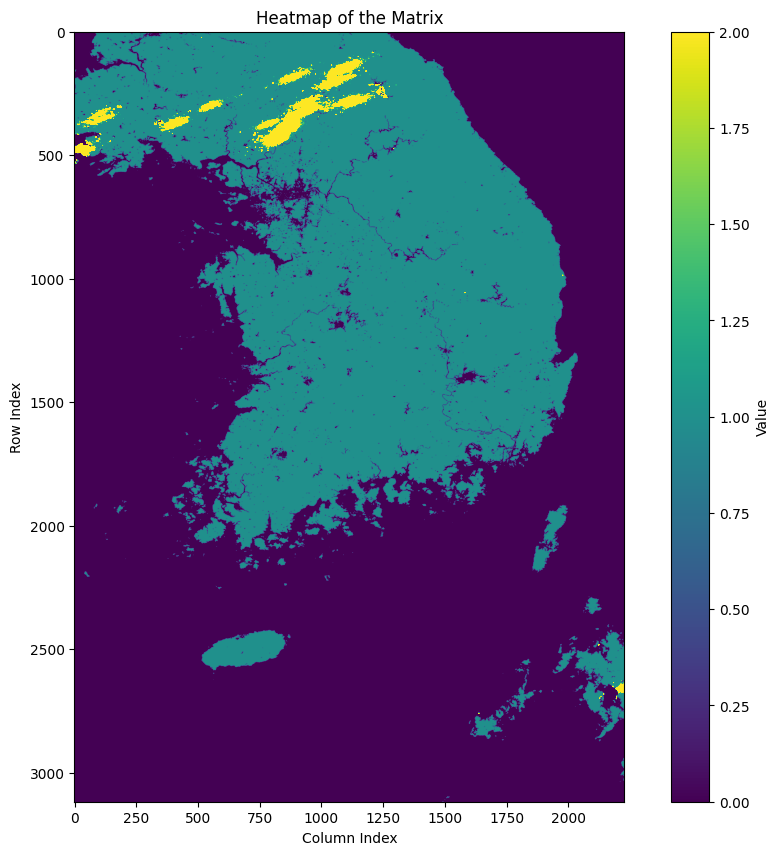

In [51]:
# quick exploration of the data
plt.figure(figsize=(12, 10))
plt.imshow(training_data[122], cmap='viridis', vmin=0, vmax=2)  # 'aspect=auto' adjusts the aspect ratio to fit the dimensions
plt.colorbar(label='Value')
plt.title("Heatmap of the Matrix")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [6]:
# Create windowed training dataset
window_size = 2  # Using x amount of months of data to predict the next month
X, y = create_windowed_dataset(normalized_dataset, window_size)
print(f'x shape/dtype: {X.shape} {X.dtype}, y shape/dtype: {y.shape} {y.dtype}')

x shape/dtype: (238, 2, 3118, 2227) float16, y shape/dtype: (238, 3118, 2227) float16


In [7]:
train, test, val = train_test_split(X, y, 188, 24, 24)
X_train, y_train = train
X_test, y_test = test
X_val, y_val = val

Train Shape: X=(188, 2, 3118, 2227), y=(188, 3118, 2227)
Test Shape: X=(24, 2, 3118, 2227), y=(24, 3118, 2227)
Validation Shape: X=(24, 2, 3118, 2227), y=(24, 3118, 2227)


# Data visualisation

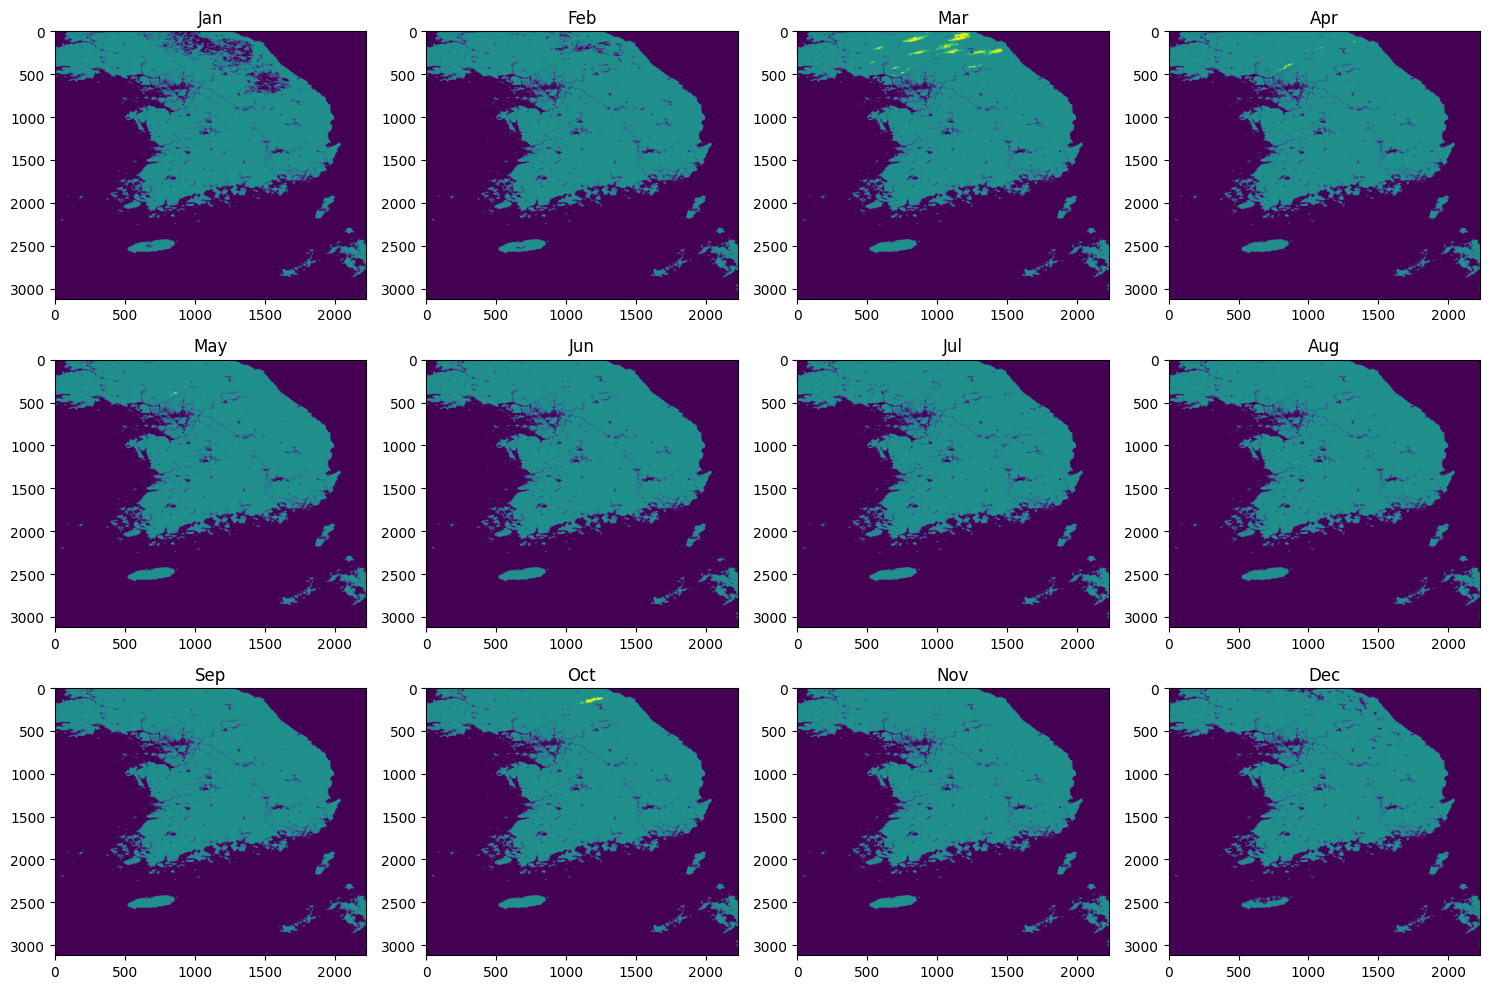

In [10]:
# Plot the fires per month on 12 seperate subplots over a span of 2 years
def plot_fires_per_month(data, last_years=6, vmin=0, vmax=2):
    """
    Plot the fire occurrences per month over the span of the last specified years
    using imshow.

    :param data: A numpy array of shape (months, height, width).
    :param last_years: Number of years to include in the plot.
    """
    num_months = 12
    total_months = last_years * num_months
    start_month = data.shape[0] - total_months

    # Plotting
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    axs = axs.flatten()
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    for i in range(num_months):
        month_index = start_month + i
        axs[i].imshow(data[month_index % data.shape[0]], cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
        axs[i].set_title(f"{month_labels[i]}")
        axs[i].axis('on')  # Hide axis for image plot

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming 'data' is your dataset with shape (240, 3118, 2227)
# Replace this with your actual dataset
plot_fires_per_month(classification_data, last_years=6, vmin=0, vmax=2)

In [15]:
def count_pixel_occurrences(dataset):
    """
    Count the occurrences of a specific value (2) in each pixel across all months.

    :param dataset: A numpy array of shape (months, height, width).
    :return: A numpy array of shape (height, width) with the count of occurrences.
    """
    months, height, width = dataset.shape
    count_matrix = np.zeros((height, width), dtype=int)

    for month in range(months):
        count_matrix += (dataset[month] == 2)

    return count_matrix / dataset.shape[0]

# Example usage
# Assuming 'dataset' is your numpy array with shape (x, y, z)
# dataset = ... (your data here)

# Forecasting model using Sigmoid

In [13]:
# ConvLSTM Model architecture

# Set the global policy to mixed_float16
# set_global_policy('mixed_float16')

model = Sequential()

# ConvLSTM layers with reduced spatial dimensions
model.add(ConvLSTM2D(filters=6, kernel_size=(3, 3), activation='relu', padding="same", data_format="channels_last", input_shape=(2, 3118, 2227, 1), return_sequences=False))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layers to rebuild the spatial dimensions
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(3, 3)))

# Output layer
model.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
model.add(Resizing(height=3118, width=2227))
# model.add(Reshape((3118, 2227)))

model.compile(optimizer='adam', loss='mean_squared_error', metrics="mae")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 3118, 2227, 6)     1536      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1039, 742, 6)     0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 1039, 742, 6)      330       
                                                                 
 up_sampling2d (UpSampling2D  (None, 3117, 2226, 6)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3117, 2226, 1)     55        
                                                                 
 resizing (Resizing)         (None, 3118, 2227, 1)     0

# Per pixel classification model

In [11]:
# Set the global policy to mixed_float16
# set_global_policy('mixed_float16')

model = Sequential()

# ConvLSTM layers with reduced spatial dimensions
model.add(ConvLSTM2D(filters=6, kernel_size=(3, 3), activation='relu', padding="same", data_format="channels_last", input_shape=(2, 3118, 2227, 1), return_sequences=False))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layers to rebuild the spatial dimensions
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(3, 3)))

# Output layer
model.add(Conv2D(filters=3, kernel_size=(3, 3), padding='same'))
model.add(Softmax(axis=-1))  # Apply softmax across the channels

model.add(Resizing(height=3118, width=2227))
# model.add(Reshape((3118, 2227)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 3118, 2227, 6)     1536      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1039, 742, 6)     0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 1039, 742, 6)      330       
                                                                 
 up_sampling2d (UpSampling2D  (None, 3117, 2226, 6)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3117, 2226, 3)     165       
                                                                 
 softmax (Softmax)           (None, 3117, 2226, 3)     0

# Month indicated per time slice ConvLSTM model

In [20]:
# Set the global policy to mixed_float16
# set_global_policy('mixed_float16')

model = Sequential()

# ConvLSTM layers with reduced spatial dimensions
model.add(ConvLSTM2D(filters=6, kernel_size=(3, 3), activation='relu', padding="same", data_format="channels_last", input_shape=(2, 447, 1114, 15), return_sequences=False))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layers to rebuild the spatial dimensions
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(3, 3)))


# Output layer
model.add(Conv2D(filters=3, kernel_size=(3, 3), padding='same'))
model.add(Softmax(axis=-1))  # Apply softmax across the channels

model.add(Resizing(height=447, width=1114))
# model.add(Reshape((3118, 2227)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 447, 1114, 6)      4560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 371, 6)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 149, 371, 6)       330       
                                                                 
 up_sampling2d (UpSampling2D  (None, 447, 1113, 6)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 447, 1113, 3)      165       
                                                                 
 softmax (Softmax)           (None, 447, 1113, 3)      0

# Train either of the three models

In [13]:
def data_generator(X_data, y_data, batch_size):
    """
    Generator function for creating batches of training data.
    
    :param X_data: The complete set of training features
    :param y_data: The complete set of training labels
    :param batch_size: The size of the batches to produce
    
    :yield: A tuple (X_batch, y_batch) where
            X_batch is a batch of training features and
            y_batch is the corresponding batch of training labels
    """
    num_samples = X_data.shape[0]
    indices = np.arange(num_samples)
    
    while True:  # Loop indefinitely, the generator will be part of the training loop
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            
            # Initialize batches
            X_batch = np.empty((len(batch_indices), *X_data.shape[1:]), dtype=X_data.dtype)
            y_batch = np.empty((len(batch_indices), *y_data.shape[1:]), dtype=y_data.dtype)
            
            # Populate batches with data
            for i, idx in enumerate(batch_indices):
                X_batch[i] = X_data[idx]
                y_batch[i] = y_data[idx]
            
            yield X_batch, y_batch


In [22]:
# Train the network
batch_size = 1  # Any bigger and VRAM will be exhausted sadly
train_gen = data_generator(X_train, y_train, batch_size)
val_gen = data_generator(X_val, y_val, batch_size)

steps_per_epoch = np.ceil(X_train.shape[0] / batch_size)
validation_steps = np.ceil(X_val.shape[0] / batch_size)

history = model.fit(
    x=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_gen,
    validation_steps=validation_steps
)

Epoch 1/10
188/188 [==============================] - 26s 106ms/step - loss: 0.4825 - accuracy: 0.8426 - val_loss: 0.1058 - val_accuracy: 0.9762
Epoch 2/10
188/188 [==============================] - 19s 103ms/step - loss: 0.1394 - accuracy: 0.9624 - val_loss: 0.0999 - val_accuracy: 0.9782
Epoch 3/10
188/188 [==============================] - 19s 103ms/step - loss: 0.1300 - accuracy: 0.9640 - val_loss: 0.0985 - val_accuracy: 0.9792
Epoch 4/10
188/188 [==============================] - 20s 104ms/step - loss: 0.1258 - accuracy: 0.9650 - val_loss: 0.0955 - val_accuracy: 0.9800
Epoch 5/10
188/188 [==============================] - 20s 106ms/step - loss: 0.1217 - accuracy: 0.9658 - val_loss: 0.0932 - val_accuracy: 0.9807
Epoch 6/10
188/188 [==============================] - 20s 106ms/step - loss: 0.1183 - accuracy: 0.9664 - val_loss: 0.0909 - val_accuracy: 0.9811
Epoch 7/10
188/188 [==============================] - 20s 108ms/step - loss: 0.1156 - accuracy: 0.9668 - val_loss: 0.0903 - val_ac

In [36]:
# Save model.
# model.save("models\forecast_sigmoid.keras")
# model.save("models\per_pixel_classificaiton.keras")
# model.save("models\per_pixel_classificaiton_small_bb_months_added.keras")

In [37]:
# Load your model you want to use
# model = keras.models.load_model("models\forecast_sigmoid.keras")
# model = keras.models.load_model("models\per_pixel_classificaiton.keras")
model = keras.models.load_model("models\per_pixel_classificaiton_small_bb_months_added.keras")

# Plots Forecasting model

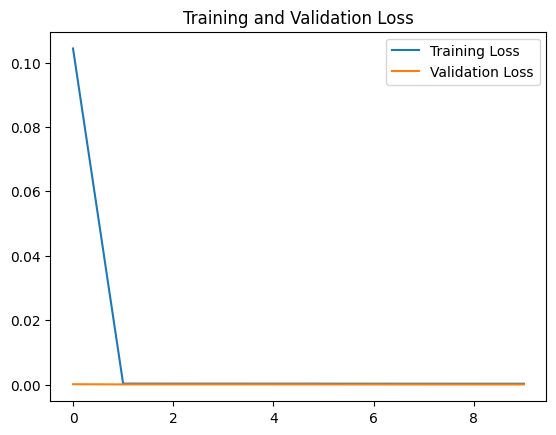

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

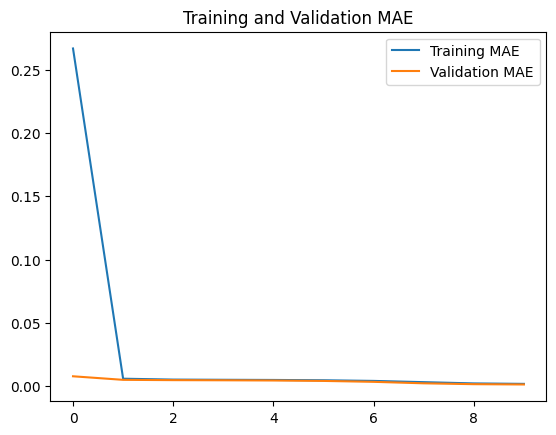

In [17]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# Plot per pixel classification

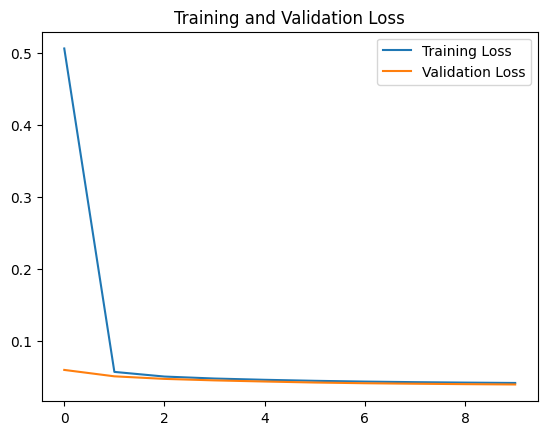

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

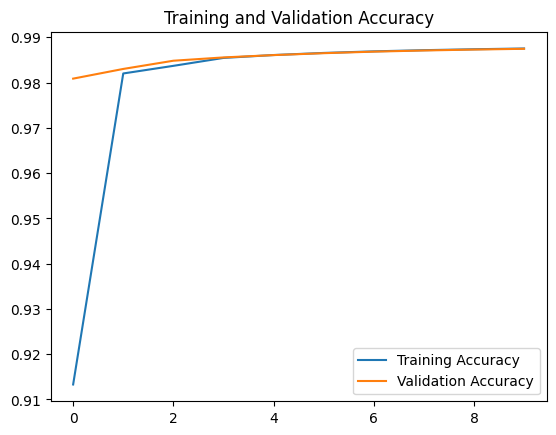

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot Per Pixel classification for the small bounding box model

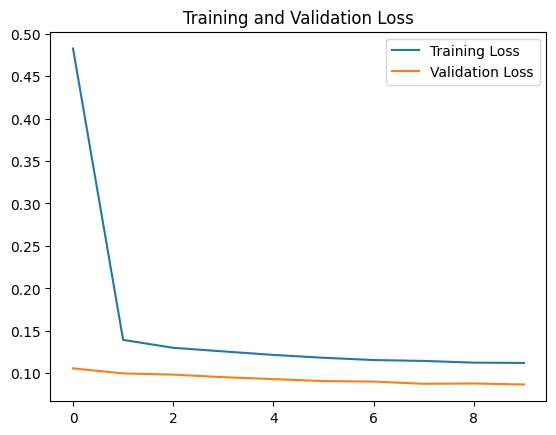

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

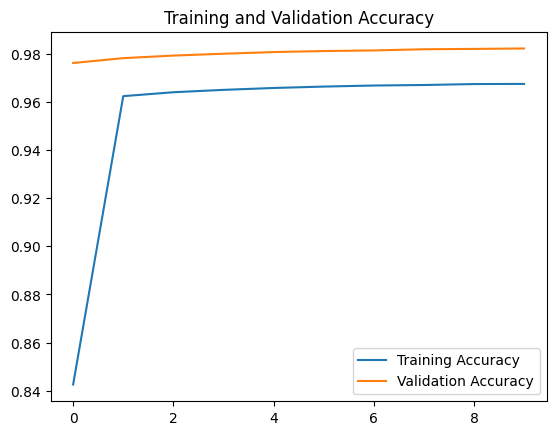

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [16]:
def predict_data_generator(X_data, batch_size):
    """
    Generator function for creating batches of data for prediction.

    :param X_data: The complete set of features for prediction (temporal, height, width, channels).
    :param batch_size: The size of the batches to produce.

    :yield: A batch of data for prediction.
    """
    num_samples = X_data.shape[0]
    indices = np.arange(num_samples)

    while True:  # Loop indefinitely
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_indices = indices[start_idx:end_idx]

            # Initialize batch
            X_batch = np.empty((len(batch_indices), *X_data.shape[1:]), dtype=X_data.dtype)

            # Populate batch with data
            for i, idx in enumerate(batch_indices):
                X_batch[i] = X_data[idx]

            yield X_batch

# Usage
# Assuming X_test is your test feature array
# test_gen = predict_data_generator(X_test, batch_size)
# predictions = model.predict(test_gen, steps=num_steps)

In [20]:
# Evaluate the model using the Data generator
batch_size = 1
test_gen = data_generator(X_test, y_test, batch_size)

# Calculate the number of steps
test_steps = np.ceil(X_test.shape[0] / batch_size)

# Evaluate the model using the generator
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {test_loss}, Test ACC: {test_acc}")

24/24 [==============================] - 5s 57ms/step - loss: 0.0997 - accuracy: 0.9695
Test Loss: 0.09967615455389023, Test ACC: 0.9695320129394531


In [21]:
# Define the batch size
batch_size = 1  # Adjust this according to your system's capability

# Create the generator
test_gen = predict_data_generator(X_test, batch_size)

# Calculate the number of steps
num_steps = np.ceil(X_test.shape[0] / batch_size)

# Use model.predict
predictions = model.predict(test_gen, steps=num_steps)

24/24 [==============================] - 1s 45ms/step


The next function is only used for the results of the second and third model

In [22]:
# Get highest prob from the probability vector and fill it with the correct class number.
def extract_class_predictions(predictions):
    """
    Extract the class with the highest probability for each pixel.

    :param predictions: A numpy array of shape (num_samples, height, width, num_classes)
                        containing the probability distribution for each class.
    :return: A numpy array of shape (num_samples, height, width) with the predicted class for each pixel.
    """
    # Use np.argmax to find the index of the maximum value along the last axis (class axis)
    predicted_classes = np.argmax(predictions, axis=-1)

    return predicted_classes

# Example usage
# Assuming 'predictions' is your model's output of shape (24, 3118, 2227, 3)
# predictions = ... (your model's prediction result)
predicted_classes = extract_class_predictions(predictions)
observation_classes = extract_class_predictions(y_test)

# 'predicted_classes' now contains the predicted class (0, 1, or 2) for each pixel
print(predicted_classes.shape)  # This should be (24, 3118, 2227)
print(observation_classes.shape)

(24, 447, 1114)
(24, 447, 1114)


In [23]:
print(np.unique(predicted_classes))
print(np.unique(observation_classes))

[0 1 2]
[0 1 2]


In [123]:
# Use block for exploration of results if something seems off


# Visualise results

### Frequency graph generation

In [24]:
prediction_matrix = count_pixel_occurrences(predicted_classes)
print(f'Unique values in the matrix: {np.unique(prediction_matrix)}')

y_test = y[214:]
observation_matrix = count_pixel_occurrences(y_test)
print(f'Unique values in the matrix: {np.unique(observation_matrix)}')

Unique values in the matrix: [0.         0.08333333 0.16666667]
Unique values in the matrix: [0.         0.04166667 0.08333333 0.125     ]


In [25]:
def combine_matrices(matrix1, matrix2):
    """
    Combine two matrices into a new matrix where each pixel contains a tuple of values from both matrices.

    :param matrix1: A numpy array of shape (x, y).
    :param matrix2: A numpy array of shape (x, y).
    :return: A numpy array of shape (x, y) with tuples as elements.
    """
    if matrix1.shape != matrix2.shape:
        raise ValueError("Both matrices must have the same shape")

    height, width = matrix1.shape
    combined_matrix = np.empty((height, width), dtype=object)

    for i in range(height):
        for j in range(width):
            combined_matrix[i, j] = (matrix1[i, j], matrix2[i, j])

    return combined_matrix

# Example usage:
# Assuming matrix1 and matrix2 are your numpy arrays with shape (x, y)
# matrix1 = ... (your first matrix here)
# matrix2 = ... (your second matrix here)

In [26]:
freq_matrix = combine_matrices(prediction_matrix, observation_matrix)

In [53]:
def create_scatter_plot(matrix):
    """
    Create a scatter plot from a matrix of tuples, where the first value in each tuple is plotted on the y-axis
    and the second value is plotted on the x-axis.

    :param matrix: A numpy array of shape (x, y) with tuples as elements.
    """
    # Extracting x and y values from the tuples
    x_values = np.array([elem[1] for row in matrix for elem in row])
    y_values = np.array([elem[0] for row in matrix for elem in row])

    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, alpha=0.5, label='pixel burn frequency')
    plt.xlabel('Observation')
    plt.ylabel('Prediction')

    # Drawing the line y = x
    max_value = max(max(x_values), max(y_values))
    plt.plot([0, max_value], [0, max_value], 'r--', label='y=x')  # Red dashed line

    plt.title('Scatter Plot of Predictions vs Observations')
    plt.legend()
    plt.show()

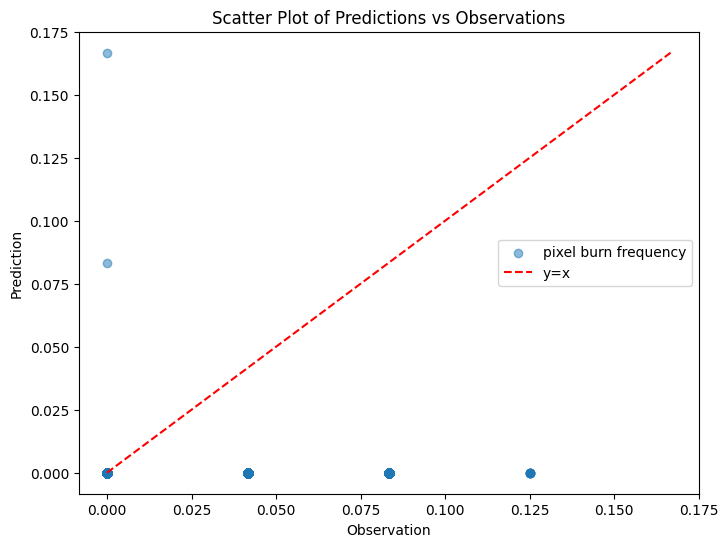

In [54]:
create_scatter_plot(freq_matrix)

In [ ]:
for i in range(prediction_matrix.shape[0]):
    print(np.unique(prediction_matrix[i]))

In [31]:
def compare_prediction_observation(prediction, observation, vmin, vmax):
    """
    Compare the prediction against the observation in a plot using imshow.

    :param prediction: A numpy array of shape (3118, 2227) representing the model's prediction.
    :param observation: A numpy array of shape (3118, 2227) representing the actual observation.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot prediction
    axs[0].imshow(prediction, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0].set_title('Prediction')
    axs[0].axis('off')

    # Plot observation
    axs[1].imshow(observation, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title('Observation')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

### Predication VS Observation of the first model

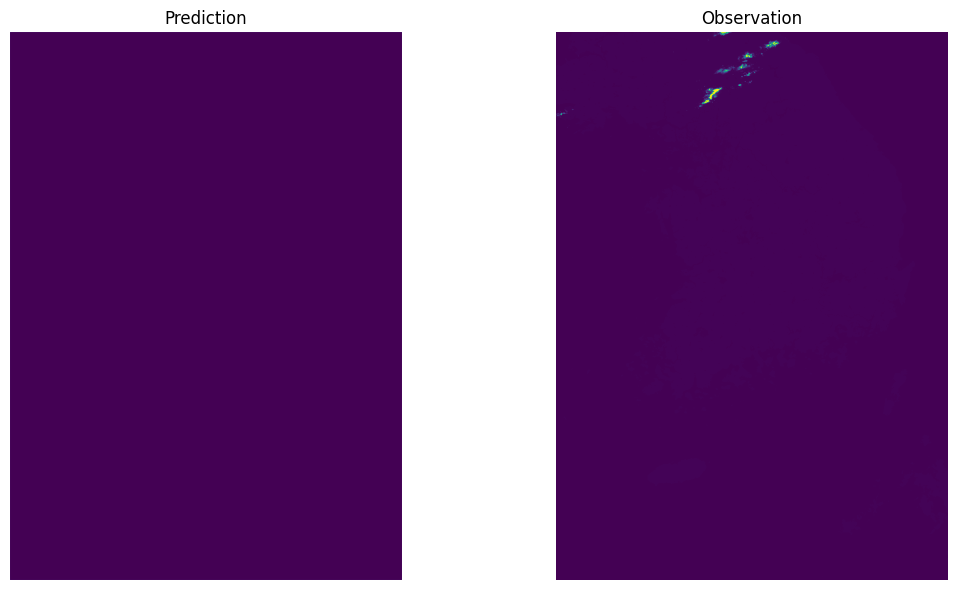

In [18]:
# Example usage
# Replace these with your actual prediction and observation arrays
compare_prediction_observation(predictions[5], y_test[5], 0 , 1)

In [98]:
# Block to be used for data exploration if something doesn't make sense


(24, 3118, 2227)

### Prediction VS Obvervation of the second model

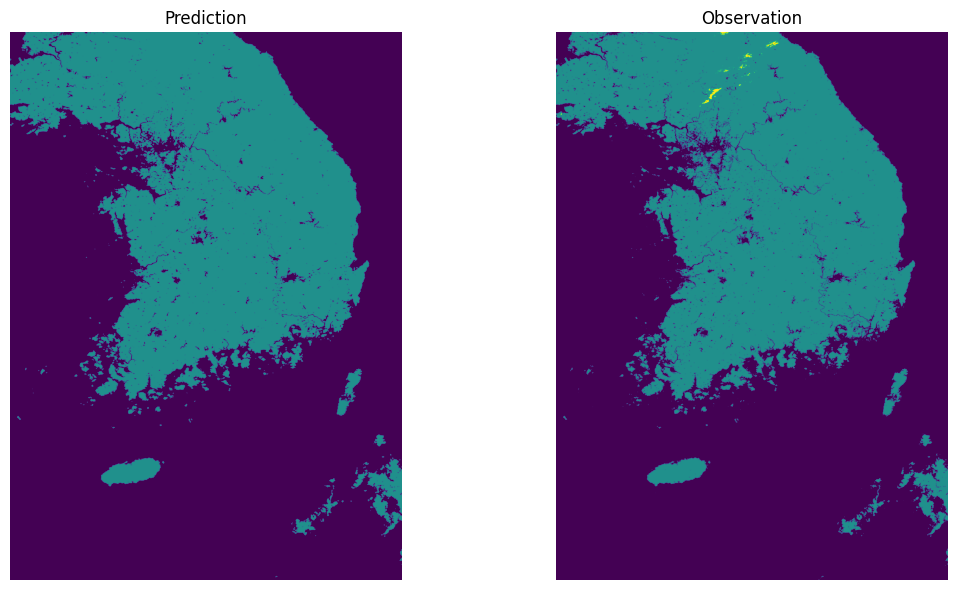

In [154]:
compare_prediction_observation(predicted_classes[5], observation_classes[5], 0, 2)

In [155]:
# Block to be used for data exploration if something doesn't make sense

# Check whether any month in the prediction of the model contains the burned class value (2)
for i in range(predicted_classes.shape[0]):
    print(np.unique(predicted_classes[i]))

### Prediction VS Obvervation of the third model

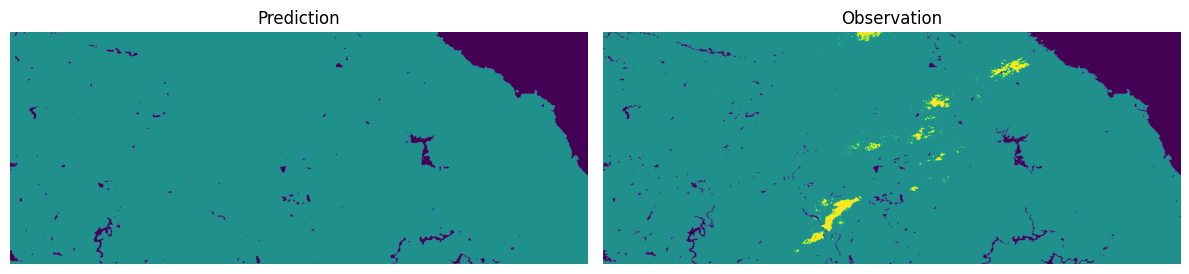

In [44]:
compare_prediction_observation(predicted_classes[5], observation_classes[5], vmin=0, vmax=2)

In [ ]:
# Block to be used for data exploration if something doesn't make sense
for i in range(predicted_classes.shape[0]):
    print(np.unique(predicted_classes[i]))

# Auxiliary code

In [51]:
# Assuming X_train is your numpy array
num_elements = np.size(X_train)
element_size_bytes = X_train.itemsize
total_size_bytes = num_elements * element_size_bytes
total_size_gb = total_size_bytes / (1024**3)  # Convert from bytes to gigabytes

print(f"Size of X_train in gigabytes: {total_size_gb} GB")

Size of X_train in gigabytes: 4.863112300634384 GB


In [15]:
# Clear accumulated VRAM
cuda.devices.reset()

In [8]:
# Test code
for layer in model.layers:
    print(layer.compute_dtype)

float32
float32
float32
float32
float32
float32
float32
